In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_excel('BPI.xlsx')

mm_data['Team2_BPI'].tail()

1107    10.9
1108    13.7
1109    14.1
1110     3.5
1111    15.8
Name: Team2_BPI, dtype: float64

In [4]:
#get columns

mm_data.columns

Index(['team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc', 'num_ot',
       'team1_position', 'team2_position', 'team1_seed', 'team2_seed',
       ...
       'team1_de', 'team1_adjde', 'team2_tempo', 'team2_adjtempo', 'team2_oe',
       'team2_adjoe', 'team2_de', 'team2_adjde', 'game_id', 'result'],
      dtype='object', length=107)

In [5]:
#feature transformation of distance

mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

In [7]:
###E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

In [8]:
####P(W) = (A - A B) / (A + B - 2A*B)
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [9]:
mm_data[['team1_adjoe','team1_teamname','Team1_BPI','season','team2_teamname','Team2_BPI','team1_adjde','exp_win1','exp_win2','team1_log5']].tail()

,team1_adjoe,team1_teamname,Team1_BPI,season,team2_teamname,Team2_BPI,team1_adjde,exp_win1,exp_win2,team1_log5
1107,108.7,Loyola-Chicago,3.5,2018,Kansas St,10.9,93.9,0.843322,0.675772,0.720863
1108,111.2,Michigan,15.8,2018,Florida St,13.7,96.5,0.836246,0.734879,0.648177
1109,122.8,Villanova,13.5,2018,Kansas,14.1,99.9,0.914781,0.824472,0.695616
1110,111.2,Michigan,15.8,2018,Loyola-Chicago,3.5,96.5,0.836246,0.843322,0.486853
1111,122.8,Villanova,13.5,2018,Michigan,15.8,99.9,0.914781,0.836246,0.677630


In [10]:
###Seed Diff
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [11]:
## BPI difference
mm_data['BPI_Diff']=mm_data['Team1_BPI'] -mm_data['Team2_BPI']


In [12]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id','Team1_BPI', 'Team2_BPI','BPI_Diff']].tail()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id,Team1_BPI,Team2_BPI,BPI_Diff
1107,2018-1260-1243,0.843322,0.675772,62.0,78,-284.535852,0.720863,1260,1243,3.5,10.9,-7.4
1108,2018-1276-1199,0.836246,0.734879,54.0,58,-75.859795,0.648177,1276,1199,15.8,13.7,2.1
1109,2018-1437-1242,0.914781,0.824472,79.0,95,1311.108325,0.695616,1437,1242,13.5,14.1,-0.6
1110,2018-1276-1260,0.836246,0.843322,57.0,69,242.765505,0.486853,1276,1260,15.8,3.5,12.3
1111,2018-1437-1276,0.914781,0.836246,62.0,79,465.785620,0.677630,1437,1276,13.5,15.8,-2.3


In [13]:
###Split Data
mm_data.dropna(subset=['team1_log5'], inplace=True)

mm_data['Score_Diff']=mm_data['team1_score']-mm_data['team2_score']
mm_data['team1_win'] = mm_data['Score_Diff'].map(lambda x: 1 if x > 0 else 0)


mm_data['team1_win'].tail()

1107    1
1108    1
1109    1
1110    1
1111    1
Name: team1_win, dtype: int64

In [14]:
#Features we currently using

mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','team1_win','Score_Diff','diff_dist','team1_log5','team1_id','team2_id','Team1_BPI', 'Team2_BPI','BPI_Diff']].tail()

,game_id,exp_win1,exp_win2,team2_score,team1_score,team1_win,Score_Diff,diff_dist,team1_log5,team1_id,team2_id,Team1_BPI,Team2_BPI,BPI_Diff
1107,2018-1260-1243,0.843322,0.675772,62.0,78,1,16.0,-284.535852,0.720863,1260,1243,3.5,10.9,-7.4
1108,2018-1276-1199,0.836246,0.734879,54.0,58,1,4.0,-75.859795,0.648177,1276,1199,15.8,13.7,2.1
1109,2018-1437-1242,0.914781,0.824472,79.0,95,1,16.0,1311.108325,0.695616,1437,1242,13.5,14.1,-0.6
1110,2018-1276-1260,0.836246,0.843322,57.0,69,1,12.0,242.765505,0.486853,1276,1260,15.8,3.5,12.3
1111,2018-1437-1276,0.914781,0.836246,62.0,79,1,17.0,465.785620,0.677630,1437,1276,13.5,15.8,-2.3


In [17]:
def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)
my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))
##m_data[(~mm_data.index.isin(my_randoms))&(mm_data.season == 2015).shape

In [18]:
mm_data = shuffle(mm_data)

In [19]:

my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))

In [20]:
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2016)].shape

(33, 117)

In [21]:
mm_data_1 = mm_data[~mm_data.index.isin(my_randoms)][['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff','Score_Diff','BPI_Diff','Team1_BPI','Team2_BPI']].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(my_randoms)][['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff','Score_Diff','BPI_Diff','Team1_BPI','Team2_BPI']].reset_index(drop=True)

In [22]:
mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data['seed_diff'] = mm_data['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff','Score_Diff','BPI_Diff','Team1_BPI','Team2_BPI']


In [23]:
mm_train = pd.concat([mm_data_2, mm_data_1])

In [24]:
mm_data_2017 = mm_train[mm_train['season'] == 2017].reset_index(drop=True)
mm_data_else =  mm_train[mm_train['season'] != 2017 ].reset_index(drop=True)
mm_data_2018 = mm_train[mm_train['season'] == 2018].reset_index(drop = True)
mm_data_else2 = mm_train[mm_train['season'] != 2018].reset_index(drop=True)


In [25]:
##Innitial Check
#mm_data_else.groupby('team1_win')['team1_log5'].mean()
mm_data_2017[['team1_id','team2_id']].groupby(['team1_id','team2_id'])['team2_id'].count()


team1_id  team2_id
1112      1315        1
          1388        1
1116      1371        1
1124      1308        1
          1425        1
1139      1292        1
          1457        1
1153      1243        1
1181      1407        1
1196      1190        1
          1438        1
          1458        1
1199      1195        1
1211      1321        1
          1355        1
          1376        1
          1452        1
          1462        1
1235      1305        1
1242      1277        1
          1345        1
          1413        1
1243      1448        1
1246      1297        1
          1417        1
          1455        1
1257      1240        1
1276      1257        1
          1329        1
1277      1274        1
                     ..
1314      1411        1
1321      1435        1
1323      1343        1
1332      1233        1
          1242        1
          1276        1
          1348        1
1345      1235        1
          1436        1
1348      1166       

In [26]:
mm_data_else.groupby('team1_win')['seed_diff'].mean()


team1_win
0   -3.346591
1   -3.951644
Name: seed_diff, dtype: float64

In [27]:
mm_data_else.groupby('team1_win')['diff_dist'].mean()

team1_win
0    169.409607
1   -165.961334
Name: diff_dist, dtype: float64

In [28]:
###Train Logit
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5']])
mm_train_scaled2 = scaler.fit_transform(mm_data_else2[['team1_log5']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else['team1_log5']).fit()
smlogit2 = sm.Logit(mm_data_else2['team1_win'],mm_data_else2['team1_log5']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.672029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668589
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1045
Model:                          Logit   Df Residuals:                     1044
Method:                           MLE   Df Model:                            0
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:                 0.03039
Time:                        15:02:30   Log-Likelihood:                -702.27
converged:                       True   LL-Null:                       -724.28
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     0.7553      0.116      6.529      0.000       0.529       0.982
==============================================================================
"""

In [30]:
mm_data_2017['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2017[['team1_log5']]))[:,1]
mm_data_2018['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2018[['team1_log5']]))[:,1]
mm_data_2017['prediction'] = logit.predict(scaler.fit_transform(mm_data_2017[['team1_log5']]))
mm_data_2018['prediction'] = logit.predict(scaler.fit_transform(mm_data_2018[['team1_log5']]))

In [31]:
mm_data_2017[['team1_log5','team1_win','preds','prediction']]
#mm_data_2018[['team1_log5','team1_win','preds','prediction']]

,team1_log5,team1_win,preds,prediction
0,0.468880,0,0.493581,0
1,0.533201,0,0.573751,1
2,0.021831,0,0.093673,0
3,0.784210,0,0.825935,1
4,0.032454,0,0.098299,0
5,0.101504,0,0.133578,0
6,0.604301,0,0.657924,1
7,0.142234,0,0.159059,0
8,0.122525,0,0.146269,0
9,0.125122,0,0.147904,0


In [32]:
mm_data_2017.groupby('team1_win')['preds'].mean()

team1_win
0    0.330549
1    0.619423
Name: preds, dtype: float64

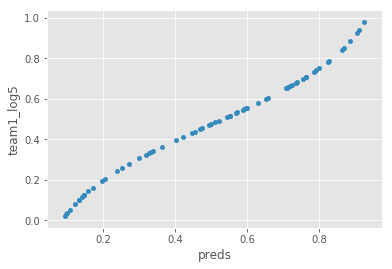

In [33]:
mm_data_2017.plot(kind='scatter', x='preds',y='team1_log5')

In [34]:
confusion_matrix(mm_data_2017['team1_win'], mm_data_2017['prediction'])

array([[20,  8],
       [11, 28]], dtype=int64)

In [35]:
accuracy_score(mm_data_2017['team1_win'], mm_data_2017['prediction'],)

0.7164179104477612

In [36]:
precision_score(mm_data_2017['team1_win'], mm_data_2017['prediction'])

0.7777777777777778

In [37]:
recall_score(mm_data_2017['team1_win'], mm_data_2017['prediction'])

0.717948717948718

In [38]:
f1_score(mm_data_2017['team1_win'], mm_data_2017['prediction'])

0.7466666666666666

In [39]:
log_loss(mm_data_2017['team1_win'].values, mm_data_2017['preds'].values)

0.5170127827356741

In [40]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

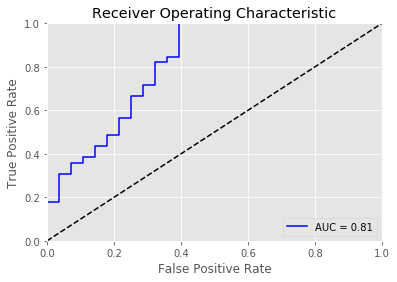

In [41]:
fpr, tpr, thresholds = roc_curve(mm_data_2017['team1_win'].values, mm_data_2017['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [42]:
roc_auc_score(mm_data_2017['team1_win'].values, mm_data_2017['preds'].values)

0.8131868131868132

In [43]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5','diff_dist','seed_diff']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else[['team1_log5','diff_dist','seed_diff']]).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.661471
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1045
Model:                          Logit   Df Residuals:                     1042
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:                 0.04562
Time:                        15:02:31   Log-Likelihood:                -691.24
converged:                       True   LL-Null:                       -724.28
                                        LLR p-value:                 4.462e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     0.8452      0.132      6.392      0.000       0.586       1.104
diff_dist     -0.0002   5.67e-05     -4.112      0.000      -0.000      -0.000
seed_diff      0.0184      0.010      1.896      0.058      -0.001       0.037
==============================================================================
"""

In [45]:
mm_data_2017['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2017[['team1_log5','diff_dist','seed_diff']]))[:,1]
mm_data_2017['prediction'] = logit.predict(scaler.fit_transform(mm_data_2017[['team1_log5','diff_dist','seed_diff']]))

In [46]:
accuracy_score(mm_data_2017['team1_win'], mm_data_2017['prediction'],)

0.7164179104477612

In [47]:
precision_score(mm_data_2017['team1_win'], mm_data_2017['prediction'])

0.7941176470588235

In [48]:
recall_score(mm_data_2017['team1_win'], mm_data_2017['prediction'])

0.6923076923076923

In [49]:
f1_score(mm_data_2017['team1_win'], mm_data_2017['prediction'])

0.7397260273972601

In [50]:
log_loss(mm_data_2017['team1_win'].values, mm_data_2017['preds'].values)

0.5284027630420873

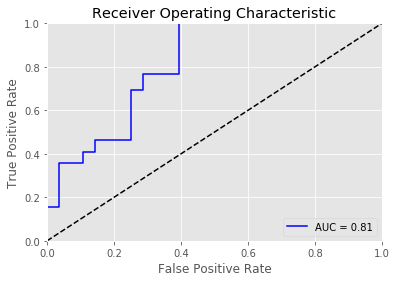

In [51]:
fpr, tpr, thresholds = roc_curve(mm_data_2017['team1_win'].values, mm_data_2017['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [52]:
roc_auc_score(mm_data_2017['team1_win'].values, mm_data_2017['preds'].values)

0.8095238095238095

In [55]:
predicted = mm_data_2017[['game_id','preds']]
predicted.to_csv("predicted.csv")
predicted2 = mm_data_2018[['game_id','preds']]
predicted2.to_csv("predicted2.csv")